In [102]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

In [103]:
#Training data INPUT 10 pair of Rainfall and Water flow historic data
#Training data OUTPUT corresponding water level data

I = np.array(([39,13.58],[33,13.33],[82,13.47],[39,13.58],[41,13.67],[8,13.71],[58,13.76],[11,13.84],[37,13.92],[14,14.04]), dtype=float)
O = np.array(([54],[75],[55],[54],[59],[25],[34],[51],[40],[56]), dtype=float)

#normalizing values
I = I/np.amax(I, axis=0)
O = O/100

In [104]:
class MLP_main(object):
    def __init__(self):
        #Definining HyperParameters
        self.inputLayerSize = 2
        self.outputLayerSize = 1
        self.hiddenLayerSize = 3
        
        #Defining random weights
        self.W1 = np.random.randn(self.inputLayerSize, self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize, self.outputLayerSize)
        
        #print (self.W1, self.W2)
        
    def forward(self, I):
        #Propagate inputs through network
        self.z2 = np.dot(I, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yHat = self.sigmoid(self.z3)
        return yHat
    
    def sigmoid(self, z):
        #Sigmoid Activation function
        return 1/(1+np.exp(-z))
    
    def sigmoidPrime(self, z):
        #Derivative of Sigmoid Function
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def costFunction(self, I, O):
        #Compute cost for given I,O using weights already stored in class.
        self.yHat = self.forward(I)
        J = 0.5*sum((O-self.yHat)**2)
        return J
    
    def costFunctionPrime (self, I, O):
        #compute derivative with respect to W1 and W2
        self.yHat = self.forward(I)
        
        delta3 = np.multiply(-(O-self.yHat),self.sigmoidPrime(self.z3))
        dJdW2 = np.dot(self.a2.T, delta3)

        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        dJdW1 = np.dot(I.T, delta2)
        
        return dJdW1, dJdW2
    
    
    #Helper Functions for interacting with other classes:
    def getParams(self):
        #Get W1 and W2 unrolled into vector:
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def setParams(self, params):
        #Set W1 and W2 using single paramater vector.
        W1_start = 0
        W1_end = self.hiddenLayerSize * self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], (self.inputLayerSize , self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], (self.hiddenLayerSize, self.outputLayerSize))
        
    def computeGradients(self, I, O):
        dJdW1, dJdW2 = self.costFunctionPrime(I,O)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))
        
        
    def computeNumericalGradient(self, I, O):
        paramsInitial = self.getParams()
        numgrad = np.zeros(paramsInitial.shape)
        perturb = np.zeros(paramsInitial.shape)
        e = 1e-4

        for p in range(len(paramsInitial)):
            #Set perturbation vector
            perturb[p] = e
            self.setParams(paramsInitial + perturb)
            loss2 = self.costFunction(I, O)
            
            self.setParams(paramsInitial - perturb)
            loss1 = self.costFunction(I, O)

            #Compute Numerical Gradient
            numgrad[p] = (loss2 - loss1) / (2*e)

            #Return the value we changed to zero:
            perturb[p] = 0
            
        #Return Params to original value:
        self.setParams(paramsInitial)

        return numgrad

In [105]:
class trainer(object):
    def __init__(self, M):
        #Making local reference to MLP:
        self.M = M
        
    def callbackF(self, params):
        #to see cost function value as being trained
        self.M.setParams(params)
        self.J.append(self.M.costFunction(self.I, self.O))
 
        
    def costFunctionWrapper(self, params, I, O):
        #Wrapper function to setup obj fn
        self.M.setParams(params)
        cost = self.M.costFunction(I, O)
        grad = self.M.computeGradients(I, O)
        return cost, grad
           
        
    def train(self, I, O):
        #make internal variables for callback function:
        self.I = I
        self.O = O
        
        #Make empty list to store costs:
        self.J =[]
        
        params0 = self.M.getParams()
        
        #Defining BFGS (Broyden–Fletcher–Goldfarb–Shanno Algorithm) to find optimal weights
        #maximum iteration is set to 500
        options = {'maxiter' : 500, 'disp' : True}
        _res = optimize.minimize(self.costFunctionWrapper,
                                 params0, jac = True, 
                                 method='BFGS', 
                                 args = (I, O), 
                                 options=options, 
                                 callback=self.callbackF)
        
        self.M.setParams(_res.x)
        self.optimizationResults = _res

In [106]:
MLP = MLP_main()

In [107]:
T = trainer(MLP)

In [108]:
T.train(I,O)

Optimization terminated successfully.
         Current function value: 0.005473
         Iterations: 153
         Function evaluations: 180
         Gradient evaluations: 180


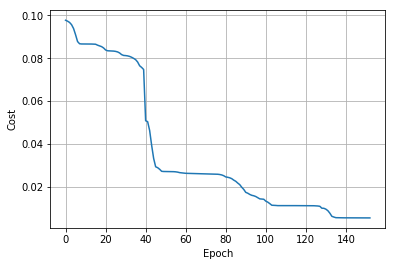

In [109]:
#ploting cost vs epoch
plt.plot(T.J)
plt.grid(1)
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.show()

In [110]:
Output_after_training = MLP.forward(I)
Output_after_training = np.round(Output_after_training,2)
#printing Desired Output and Actual Output after training :
print("Desired Flood Level : ", np.matrix.transpose(O) * 100)
print("Actual Flood Level  : ", np.matrix.transpose(Output_after_training)*100)

Desired Flood Level :  [[ 54.  75.  55.  54.  59.  25.  34.  51.  40.  56.]]
Actual Flood Level  :  [[ 58.  73.  55.  58.  52.  25.  33.  53.  44.  53.]]
